%%latex
\tableofcontents

# Preparations 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
# qt backend for interactive windows
%matplotlib qt 

In [2]:
# ENV_NAME = 'colab'
ENV_NAME = 'local'
path_prefix = {'colab': '/content/drive/MyDrive/ComputerVision/CV-Phase1/', 
                'local': './Images/'}

Open image using pyplot:

In [3]:
def loadImage(name, path_prefix=path_prefix[ENV_NAME]):
  image = plt.imread(path_prefix + name)
  print(image.shape)
  print(type(image))
  return image

# Mapping to Cube Using Affine Transforms
<a id="map_to_cube"></a>

In [4]:
girl_img = loadImage('girl.bmp')

(512, 512, 3)
<class 'numpy.ndarray'>


The Numpy array's shape is 512×512×3, the last dimension giving the three bands of the image. We can use them individually to view the single band versions in each channel (here channels use greyscale mapping, but can easily be changed using pyplot's various colourmaps).

In [4]:
# set colour map to greyscale 
# for upcoming pyplot figures
plt.gray() 

<Figure size 432x288 with 0 Axes>

We define a function to convert an rgb (3-band) image to a single-band greyscale one. The function is based on Matlab's `greyscale` function.

Opening and reviewing the other two images quickly:

(512, 512, 3)
<class 'numpy.ndarray'>
(512, 512, 3)
<class 'numpy.ndarray'>


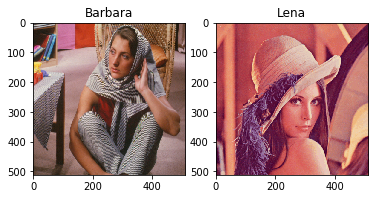

In [8]:
barb_img = loadImage('barbara.bmp')
lena_img = loadImage('lena.bmp')
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(barb_img)
axs[0].set_title('Barbara')
axs[1].imshow(lena_img)
axs[1].set_title('Lena')
plt.show()

## Transformation and Mapping
<a id="transform_and_map"></a>

(956, 964, 3)
<class 'numpy.ndarray'>


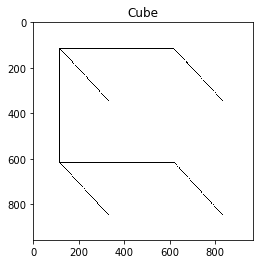

In [5]:
cube = loadImage('Cube.png')
# loaded as [0..1] float
# change to [0..255] int
cube = (cube*255).astype(np.uint8)
plt.title('Cube')
plt.imshow(cube)

The first transformations we need for the Girl are shear and scale. Starting by ${c_x = 2}$ and ${s_x = 1}$, we use trial and error approach to find the best fit. By multiplying the two transformation matrices we reach the single `T` matrix which will be used for the transform.

This implementation uses backward transformation, i.e. we iterate over an empty transformed image and fill it using inverse transform on the coordinates to find the initial pixel location (in the input image), to fill in the gaps that occur in the transformed image, we need an interpolation algorithm, here a simple Nearest Neighbours is implemented for this purpose.

<a id='affine_transforms'></a>

In [6]:
# (i, j): pixel location in transformed image
# img: initial image (untransformed)
# T_inv: inverse of the transformation matrix
def nearest_neighbours(i, j, img, T_inv):
  # image bounds
  x_max, y_max = img.shape[0] - 1, img.shape[1] - 1
  # location in original image
  x, y, _ = T_inv @ np.array([i, j, 1])
  if np.floor(x) == x and np.floor(y) == y:
    x, y = int(x), int(y)
  else:
    if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
      x = int(np.floor(x))
    else:
      x = int(np.ceil(x))
    if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
      y = int(np.floor(y))
    else:
      y = int(np.ceil(y))
  # if bounds exceed or negative coordinates appear
  # the image is black (no intensity, empty in these areas)
  if x > x_max or y > y_max or x < 0 or y < 0:
    return np.zeros(img.shape[2])
  return img[x, y,]

In [7]:
# (i, j): pixel location in transformed image
# img: initial image (untransformed)
# T_inv: inverse of the transformation matrix
def bilinear (i, j, img, T_inv):
  # image bounds
  x_max, y_max = img.shape[0] - 1, img.shape[1] - 1
  # location in original image
  x, y, _ = T_inv @ np.array([i, j, 1])
  # neighbouring coefficients
  x0, x1 = np.clip([np.floor(x).astype(int), (x+1).astype(int)], 0, x_max)
  y0, y1 = np.clip([np.floor(y).astype(int), (y+1).astype(int)], 0, y_max)
  # coefficients
  a = img[x0, y0, :]
  b = img[x0, y1, :]
  c = img[x1, y0, :]
  d = img[x1, y1, :]
  # and weights
  aw = (x1 - x) * (y1 - y)
  bw = (x1 - x) * (y - y0)
  cw = (x - x0) * (y1 - y)
  dw = (x - x0) * (y - y0)
  intensity = (np.floor((aw * a) + (bw * b) + (cw * c) + (dw * d))).astype(int)
  return intensity
  

In [8]:
def affine_transform (img, r, c, T, interp='nearest_neighbours'):
  T_inv = np.linalg.inv(T)
  transformed = np.zeros((r, c, img.shape[2]), dtype=np.uint8)
  print(transformed.shape)
  for i, row in enumerate(transformed):
    for j, _ in enumerate(row):
      transformed[i, j,:] = globals()[interp](i, j, img, T_inv)
  return transformed

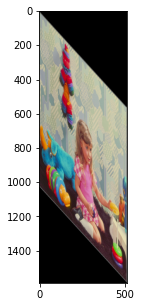

In [ ]:
T = np.array([[2, 1.1, 0],
              [0, 1, 0],
              [0, 0, 1]])
# calculate output size
out_shape = (np.ceil(np.array([girl_img.shape[0], girl_img.shape[1], 1]) @ T.transpose())) .astype(int)
girl_transformed = np.zeros((out_shape[0], out_shape[1], 3), dtype=np.uint8)
girl_transformed = affine_transform(girl_img, out_shape[0], out_shape[1], T)
plt.figure(figsize=(5,5))
plt.imshow(girl_transformed)

We can try the same transformation with bilinear interpolation. Below is the result compared to nearest neighbours.

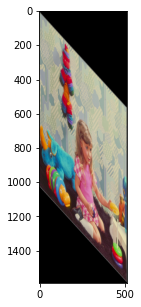

In [ ]:
T = np.array([[2, 1.1, 0],
              [0, 1, 0],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([girl_img.shape[0], girl_img.shape[1], 1]) @ T.transpose())) .astype(int)
girl_transformed_bi= np.zeros((out_shape[0], out_shape[1], 3), dtype=np.uint8)
girl_transformed_bi = affine_transform(girl_img, out_shape[0], out_shape[1],
                                       T, interp='bilinear')
plt.figure(figsize=(5,5))
plt.imshow(girl_transformed_bi)

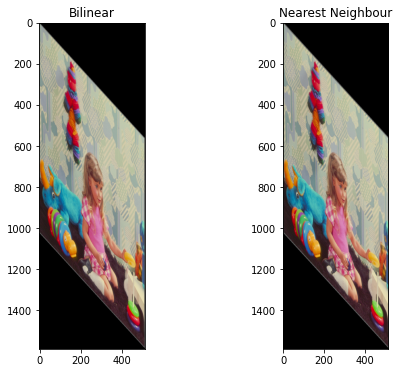

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(girl_transformed_bi)
axs[0].set_title('Bilinear')
axs[1].imshow(girl_transformed)
axs[1].set_title('Nearest Neighbour')
plt.show()

It also needs some slight rotation, found by testing small values. The ideal output occurs at ${θ = -3.2°}$.

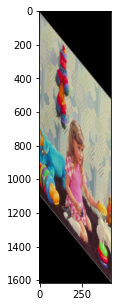

In [ ]:
import math as m
theta = -3.2
T = np.array([[m.cos(m.radians(theta)), -m.sin(m.radians(theta)), 0],
              [m.sin(m.radians(theta)), m.cos(m.radians(theta)), 0],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([girl_transformed.shape[0], girl_transformed.shape[1], 1]) @ T.transpose())).astype(int)
girl_transformed2 = np.zeros((out_shape[0], out_shape[1], 3), dtype=np.uint8)
girl_transformed2 = affine_transform(girl_transformed, out_shape[0], out_shape[1], T)
plt.figure(figsize=(5,5))
plt.imshow(girl_transformed2)

And its bilinear equivalent:

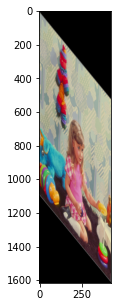

In [ ]:
import math as m
theta = -3.2
T = np.array([[m.cos(m.radians(theta)), -m.sin(m.radians(theta)), 0],
              [m.sin(m.radians(theta)), m.cos(m.radians(theta)), 0],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([girl_transformed_bi.shape[0], girl_transformed_bi.shape[1], 1]) @ T.transpose())).astype(int)
girl_transformed2_bi = np.zeros((out_shape[0], out_shape[1], 3), dtype=np.uint8)
girl_transformed2_bi = affine_transform(girl_transformed_bi, out_shape[0], out_shape[1],
                                     T, interp='bilinear')
plt.figure(figsize=(5,5))
plt.imshow(girl_transformed2_bi)

In [ ]:
girl_transformed2.shape

(1615, 423, 3)

But we need to resize the transformeed image to fit on the Cube, for this purpose we use the `resize` function from OpenCV, although we can also use the affine transforms, but this is just as well.
The interpolation used is NN to match the previous transforms.

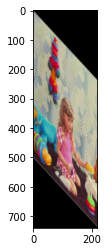

In [ ]:
import cv2
girl_scaled = cv2.resize(girl_transformed2, (218, 740), cv2.INTER_NEAREST)
plt.imshow(girl_scaled)

To mask the image on the cube, we copy all its pixels on a copy of the background and replace the black pixels (empty areas) with the original background (Cube).

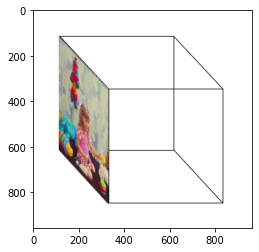

In [ ]:
cubed = np.copy(cube)
# the cube elements are of type float
height, width, _ = girl_scaled.shape
x, y = 114, 113
cubed[x:min(x+height, cubed.shape[0]), y:min(y+width, cubed.shape[1])] = girl_scaled
mask = (cubed == 0)
cubed[mask] = cube[mask]
plt.imshow(cubed)

Lena's image will be used in forefront side of the Cube, hence not needing any particular transforms (it is already a square). We could use translation on top of the cube along with resize, though.

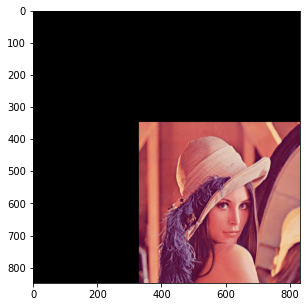

In [ ]:
T = np.array([[0.98, 0, 346],
              [0, 0.98, 330],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([lena_img.shape[0], lena_img.shape[1], 1]) @ T.transpose())).astype(int)
lena_transformed = np.zeros((out_shape[0], out_shape[1], 3), dtype=np.uint8)
lena_transformed = affine_transform(lena_img, out_shape[0], out_shape[1], T)
plt.figure(figsize=(5,5))
plt.imshow(lena_transformed)

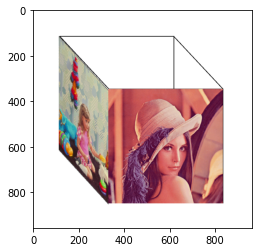

In [ ]:
cubed_2 = np.copy(cubed)
# the cube elements are of type float
height, width, _ = lena_transformed.shape
cubed_2[:min(height, cubed_2.shape[0]), :min(width, cubed_2.shape[1])] = lena_transformed
mask = (cubed_2 == 0)
cubed_2[mask] = cubed[mask]
plt.imshow(cubed_2)

No we need to shear and scale Barbara. Starting by ${c_y = 2}$ and ${s_y = 1}$, we use trial and error approach to find the best fit. 

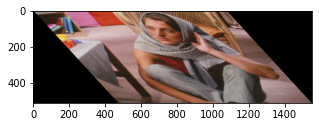

In [ ]:
T = np.array([[1, 0, 0],
              [0.93, 2.1, 0],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([barb_img.shape[0], barb_img.shape[1], 1]) @ T.transpose())).astype(int)
barb_transformed = np.zeros(out_shape, dtype=np.uint8)
barb_transformed = affine_transform(barb_img, out_shape[0], out_shape[1], T)
plt.figure(figsize=(5,5))
plt.imshow(barb_transformed)

In [ ]:
barb_transformed.shape

(512, 1552, 3)

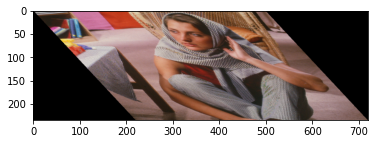

In [ ]:
barb_scaled = cv2.resize(barb_transformed, (720, 235), cv2.INTER_NEAREST)
plt.imshow(barb_scaled)

The resulting image needs translation on the cube, which is more easily achieved if done on the cube itself (though we can similarly use `(x, y)` as translation 

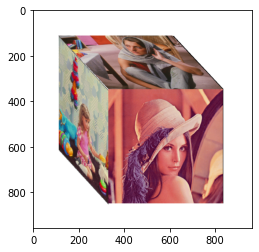

In [ ]:
cubed_3 = np.copy(cubed_2)
# the cube elements are of type float
height, width, _ = barb_scaled.shape
x, y = [112, 112]
cubed_3[x:min(x+height, cubed_3.shape[0]), y:min(y+width, cubed_3.shape[1])] = barb_scaled
mask = (cubed_3 == 0)
cubed_3[mask] = cubed_2[mask]
plt.imshow(cubed_3)

## Bilinear Equivalents
<a id="bilinear_eqs"></a>

In the previous section we introduced the bilinear interpolation algorithm and transformed the Girl using that. With a quick re-visit of the previous transforms, we put bilinearly interpolated versions of these images on the Cube.

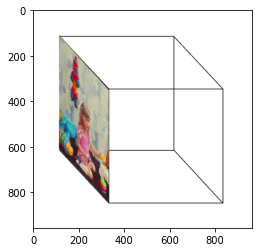

In [ ]:
import cv2
girl_scaled = cv2.resize(girl_transformed2_bi, (218, 740), cv2.INTER_LINEAR)
cubed_bi = np.copy(cube)
# the cube elements are of type float
height, width, _ = girl_scaled.shape
x, y = 110, 114 
cubed_bi[x:min(x+height, cubed_bi.shape[0]), y:min(y+width, cubed_bi.shape[1])] = girl_scaled
mask = (cubed_bi == 0)
cubed_bi[mask] = cube[mask]
plt.imshow(cubed_bi)

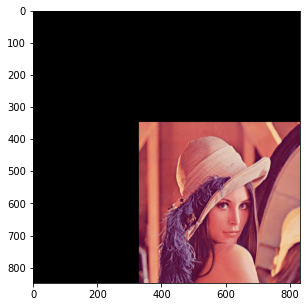

In [ ]:
T = np.array([[0.98, 0, 346],
              [0, 0.98, 330],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([lena_img.shape[0], lena_img.shape[1], 1]) @ T.transpose())).astype(int)
lena_transformed_bi = np.zeros((out_shape[0], out_shape[1], 3), dtype=np.uint8)
lena_transformed_bi = affine_transform(lena_img, out_shape[0], out_shape[1],
                                       T, interp='bilinear')
plt.figure(figsize=(5,5))
plt.imshow(lena_transformed_bi)

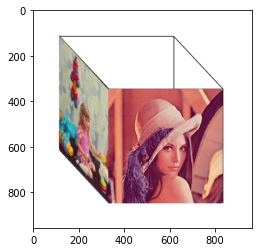

In [ ]:
cubed_2_bi = np.copy(cubed_bi)
# the cube elements are of type float
height, width, _ = lena_transformed_bi.shape
cubed_2_bi[:min(height, cubed_2_bi.shape[0]), :min(width, cubed_2_bi.shape[1])] = lena_transformed_bi
mask = (cubed_2_bi == 0)
cubed_2_bi[mask] = cubed_bi[mask]
plt.imshow(cubed_2_bi)

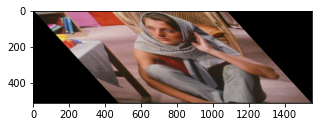

In [ ]:
T = np.array([[1, 0, 0],
              [0.93, 2.1, 0],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([barb_img.shape[0], barb_img.shape[1], 1]) @ T.transpose())).astype(int)
barb_transformed_bi = np.zeros(out_shape, dtype=np.uint8)
barb_transformed_bi = affine_transform(barb_img, out_shape[0], out_shape[1],
                                       T, interp='bilinear')
plt.figure(figsize=(5,5))
plt.imshow(barb_transformed_bi)

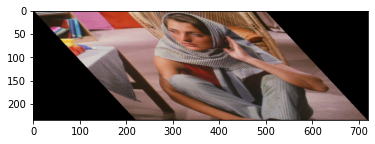

In [ ]:
barb_scaled = cv2.resize(barb_transformed_bi, (720, 235), cv2.INTER_LINEAR)
plt.imshow(barb_scaled)

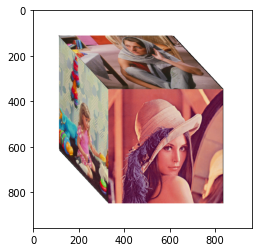

In [ ]:
cubed_3_bi = np.copy(cubed_2_bi)
# the cube elements are of type float
height, width, _ = barb_scaled.shape
x, y = [112, 112]
cubed_3_bi[x:min(x+height, cubed_3_bi.shape[0]), y:min(y+width, cubed_3_bi.shape[1])] = barb_scaled
mask = (cubed_3_bi == 0)
cubed_3_bi[mask] = cubed_2_bi[mask]
plt.imshow(cubed_3_bi)

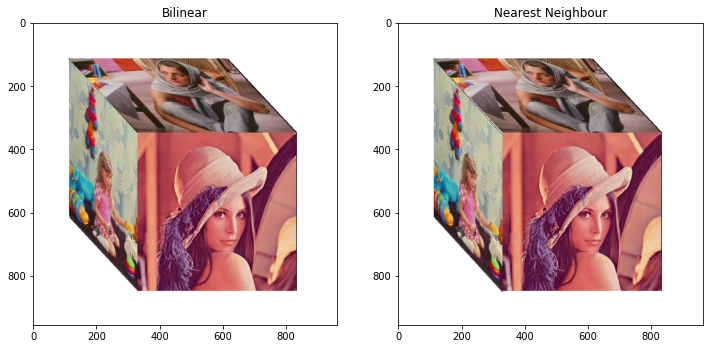

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].imshow(cubed_3_bi)
axs[0].set_title('Bilinear')
axs[1].imshow(cubed_3)
axs[1].set_title('Nearest Neighbour')
plt.show()

# Map Image Registration 
<a id="img_reg"></a>


(415, 406, 4)
<class 'numpy.ndarray'>
(394, 369, 4)
<class 'numpy.ndarray'>


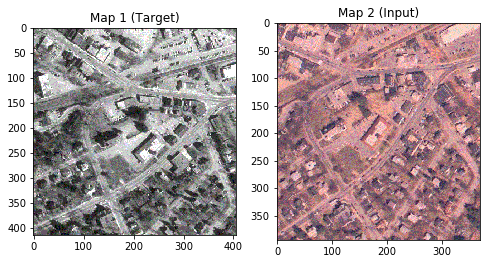

In [9]:
map1 = loadImage('Map1.gif')
map2 = loadImage('Map2.gif')
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(map1)
axs[0].set_title('Map 1 (Target)')
axs[1].imshow(map2)
axs[1].set_title('Map 2 (Input)')
plt.show()

To ease finding the correct transform, we use four feature points on each picture that correspond with each other. In image registration, it is then advised to use opencv to find the transform between the two images. However, here we have to do this part manually.
Using matplotlib in qt, we can use the mouse to click on the points on the images.
We then save these new images and preform transforms on them to find a good transform.

In [10]:
%matplotlib qt
import time
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(map1)
axs[0].set_title('Map 1 (Target)')
axs[1].imshow(map2)
axs[1].set_title('Map 2 (Input)')
plt.show()
pts1 = []
pts1 = plt.ginput(4, timeout=0)
print(pts1)
pts2 = []
pts2 = plt.ginput(4, timeout=0)
print(pts2)

[(368.3051612903226, 147.96236129032258), (244.40967741935486, 212.79139354838708), (155.08967741935487, 323.7210709677419), (147.88645161290322, 349.65268387096773)]
[(309.57903225806456, 82.61231612903231), (185.19032258064522, 169.02973548387104), (122.34129032258068, 289.49038064516134), (121.03193548387105, 313.0587677419355)]


Drawing the extracted points on the images and saving the results:

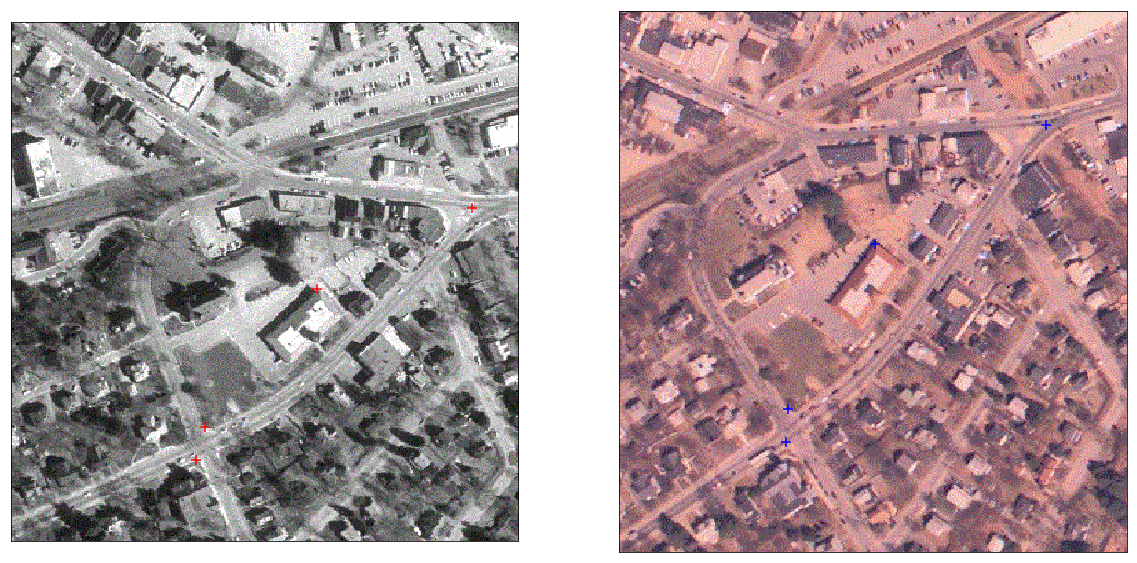

In [11]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
pts1 = np.array(pts1)
pts2 = np.array(pts2)
axs[0].imshow(map1)
axs[0].scatter(pts1[:,0], pts1[:,1], c='r', marker='+', s=100)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(map2)
axs[1].scatter(pts2[:,0], pts2[:,1], c='b', marker='+', s=100)
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()
extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('map1_features.png', bbox_inches=extent)
extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('map2_features.png', bbox_inches=extent)

(525, 514, 4)
<class 'numpy.ndarray'>
(548, 514, 4)
<class 'numpy.ndarray'>


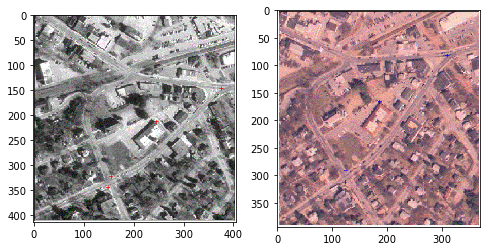

In [13]:
import cv2
fmap1 = loadImage('map1_features.png', path_prefix= './outputs/')
fmap2 = loadImage('map2_features.png', path_prefix='./outputs/')
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fmap1 = (fmap1*255).astype(np.uint8)
fmap2 = (fmap2*255).astype(np.uint8)
fmap1 = cv2.resize(fmap1, (map1.shape[1], map1.shape[0]), cv2.INTER_LINEAR)
fmap2 = cv2.resize(fmap2, (map2.shape[1], map2.shape[0]), cv2.INTER_LINEAR)
axs[0].imshow(fmap1)
axs[1].imshow(fmap2)
plt.show()

Using the affine transform functions, we can rotate the input map.

(452, 297, 4)


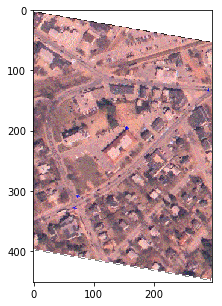

In [14]:
import math as m
alpha = 0
beta = 0
T = np.array([  [1, m.tan(m.radians(alpha)), 0],
                [m.tan(m.radians(beta)), 1, 0],
                [0, 0, 1]])
theta = -9.8
T = T @ (np.array([[m.cos(m.radians(theta)), -m.sin(m.radians(theta)), 0],
              [m.sin(m.radians(theta)), m.cos(m.radians(theta)), 0],
              [0, 0, 1]]))
out_shape = (np.ceil(np.array([fmap2.shape[0], fmap2.shape[1], 1]) @ T.transpose())).astype(int)
map2_trans = np.empty((out_shape[0], out_shape[1], 4), dtype=np.uint8)
map2_trans = affine_transform(fmap2, out_shape[0], out_shape[1], T)
plt.figure(figsize=(5,5))
plt.imshow(map2_trans)

(467, 387, 4)


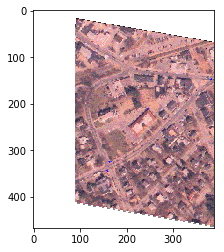

In [15]:
import math as m
T = np.array([[1, 0, 15],
              [0, 1, 90],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([map2_trans.shape[0], map2_trans.shape[1], 1]) @ T.transpose())).astype(int)
map2_translate = np.empty((out_shape[0], out_shape[1], 3), dtype=np.uint8)
map2_translate = affine_transform(map2_trans, out_shape[0], out_shape[1], T)
plt.imshow(map2_translate)

<a id="alpha_blend"></a>
The `alpha_blend` function takes a source and overlay image, and blends their pixels using the alpha channel of the source and a fraction of the alpha from overlay (default 0.6). The result is a new rgba image with the blended pixels.

In [16]:
def alpha_blend(img1, img2, coef=0.6):
  height, width = min(img2.shape[0],img1.shape[0]), min(img2.shape[1], img1.shape[1])
  overlay = np.array(img2[:height,:width,:], copy=True)
  # arbitrary alpha for overlay image
  overlay[:,:,3] = overlay[:,:,3] * coef
  src_rgb = np.array(img1[:height,:width,:3], copy=True)
  dest_rgb = overlay[...,:3]

  # alpha channel in range 0..1
  src_alpha = np.array(img1[:height,:width,3],copy=True) / 255.0
  dest_alpha = overlay[...,3] / 255.0
  out_alpha= src_alpha * (1 - dest_alpha) + dest_alpha

  img_rgb = (src_rgb * src_alpha[..., np.newaxis] * (1-dest_alpha[..., np.newaxis]) \
        + dest_rgb * dest_alpha[..., np.newaxis]) / out_alpha[..., np.newaxis]
  img_rgba = np.dstack((img_rgb,out_alpha*255)).astype(np.uint8)
  return img_rgba

The below image is a combination of the two images, with the overlay image in the foreground. The crosses are superimposed near perfectly (save for the junction on bottom left corner, which is a bit off due to incorrect selection).

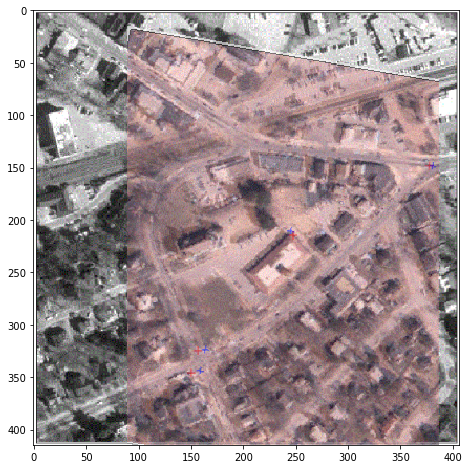

In [ ]:
%matplotlib inline
map_blend = alpha_blend(fmap1, map2_translate)
canvas = np.copy(fmap1)
height, width, _ = map_blend.shape
canvas[:min(height, canvas.shape[0]), :min(width, canvas.shape[1]), :] = map_blend
mask = (canvas == 0)
canvas[mask] = fmap1[mask]
plt.figure(figsize=(8,8))
plt.imshow(canvas)

<a id="map_registration"></a>
Now that we have a better understanding of the approximate parameters, we can use the original images. This may need a slight change in parameters as the modified images had slightly different dimensions and padding.

(452, 297, 4)


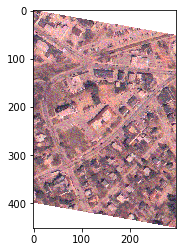

In [21]:
import math as m
# Shear
alpha = 0
beta = 0
Ts = np.array([  [1, m.tan(m.radians(alpha)), 0],
                [m.tan(m.radians(beta)), 1, 0],
                [0, 0, 1]])
# Rotation
theta = -9.8
Tr = (np.array([[m.cos(m.radians(theta)), -m.sin(m.radians(theta)), 0],
              [m.sin(m.radians(theta)), m.cos(m.radians(theta)), 0],
              [0, 0, 1]]))

T = Ts @ Tr
out_shape = (np.ceil(np.array([map2.shape[0], map2.shape[1], 1]) @ T.transpose())).astype(int)
map2_trans = np.empty((out_shape[0], out_shape[1], 4), dtype=np.uint8)
map2_trans = affine_transform(map2, out_shape[0], out_shape[1], T)
plt.imshow(map2_trans)

(465, 382, 4)


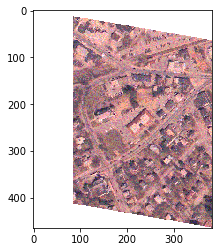

In [24]:
# Translation
tx = 13
ty = 85
Tt = np.array([[1, 0, tx],
              [0, 1, ty],
              [0, 0, 1]])
out_shape = (np.ceil(np.array([map2_trans.shape[0], map2_trans.shape[1], 1]) @ Tt.transpose())).astype(int)
map2_translate = np.empty((out_shape[0], out_shape[1], 4), dtype=np.uint8)
map2_translate = affine_transform(map2_trans, out_shape[0], out_shape[1], Tt)
plt.imshow(map2_translate)

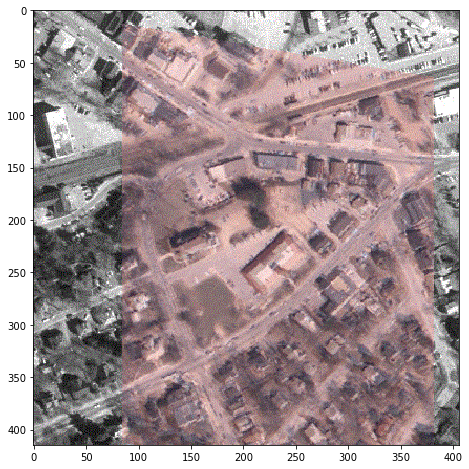

In [25]:
map_blend = alpha_blend(map1, map2_translate)
canvas = np.copy(map1)
height, width, _ = map_blend.shape
canvas[:min(height, canvas.shape[0]), :min(width, canvas.shape[1]), :] = map_blend
mask = (canvas == 0)
canvas[mask] = map1[mask]
plt.figure(figsize=(8,8))
plt.imshow(canvas)

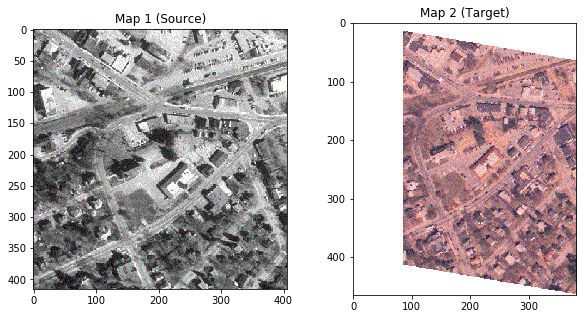

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(map1)
axs[0].set_title('Map 1 (Source)')
axs[1].imshow(map2_translate)
axs[1].set_title('Map 2 (Target)')
plt.show()